# **생체 신호 데이터 분석 실습 2**
## EEG 파형으로부터 BIS 예측

In [16]:
!pip install vitaldb
import vitaldb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.signal
import itertools as it



## Inclusion & Exclusion criteria

아래 조건을 만족하는 caseid들의 목록을 만듭니다.
0. 나이 18세 초과,
1.  BIS/EEG1_WAV
2.  BIS/BIS
3.  Primus/EXP_SEVO


In [11]:
df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track information
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # patient information

caseids = set(df_cases.loc[df_cases['age'] > 18, 'caseid']) &\
    set(df_trks.loc[df_trks['tname'] == 'BIS/EEG1_WAV', 'caseid']) &\
    set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid']) &\
    set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_SEVO', 'caseid'])

len(caseids) # The output should be 3300

3300

각 데이터 종류를 어떤 식으로 처리했는지 흐름을 유의해서 보시면 됩니다.

In [12]:
SRATE = 128  # in hz
SEGLEN = 4 * SRATE  # samples
MAX_CASES = 10

# Column order when loading data
EEG = 0
SEVO = 1
BIS = 2

x = []
y = []  # sevo
b = []  # bis
c = []  # caseids
icase = 0  # number of loaded cases
for caseid in caseids:
    print('loading {} ({}/{})'.format(caseid, icase, MAX_CASES), end='...', flush=True)

    # Excluding the following values
    if np.any(vitaldb.load_case(caseid, 'Orchestra/PPF20_CE') > 0.2):
        print('propofol')
        continue
    if np.any(vitaldb.load_case(caseid, 'Primus/EXP_DES') > 1):
        print('desflurane')
        continue
    if np.any(vitaldb.load_case(caseid, 'Primus/FEN2O') > 2):
        print('n2o')
        continue
    if np.any(vitaldb.load_case(caseid, 'Orchestra/RFTN50_CE') > 0.2):
        print('remifentanil')
        continue

    # Extract data
    vals = vitaldb.load_case(caseid, ['BIS/EEG1_WAV', 'Primus/EXP_SEVO', 'BIS/BIS'], 1 / SRATE)
    if np.nanmax(vals[:, SEVO]) < 1:
        print('all sevo <= 1')
        continue

    # Convert etsevo to the age related mac
    age = df_cases.loc[df_cases['caseid'] == caseid, 'age'].values[0]
    vals[:, SEVO] /= 1.80 * 10 ** (-0.00269 * (age - 40))

    if not np.any(vals[:, BIS] > 0):
        print('all bis <= 0')
        continue

    # Since the EEG should come out well, we start from the location where the value of bis was first calculated.
    valid_bis_idx = np.where(vals[:, BIS] > 0)[0]
    first_bis_idx = valid_bis_idx[0]
    last_bis_idx = valid_bis_idx[-1]
    vals = vals[first_bis_idx:last_bis_idx + 1, :]

    if len(vals) < 1800 * SRATE:  # Do not use cases that are less than 30 minutes
        print('{} len < 30 min'.format(caseid))
        continue

    # Forward fill in MAC value and BIS value up to 5 seconds
    vals[:, SEVO:] = pd.DataFrame(vals[:, SEVO:]).ffill(limit=5 * SRATE).values

    # Extract data every 1 second from its start to its end and then put into the dataset
    oldlen = len(y)
    for irow in range(SEGLEN, len(vals), SRATE):
        bis = vals[irow, BIS]
        mac = vals[irow, SEVO]
        if np.isnan(bis) or np.isnan(mac) or bis == 0:
            continue
        # add dataset
        eeg = vals[irow - SEGLEN:irow, EEG]
        x.append(eeg)
        y.append(mac)
        b.append(bis)
        c.append(caseid)

    # Valid case
    icase += 1
    print('{} samples read -> total {} samples ({}/{})'.format(len(y) - oldlen, len(y), icase, MAX_CASES))
    if icase >= MAX_CASES:
        break

# Change the input dataset to a numpy array
x_raw = np.array(x)
y_raw = np.array(y)
b_raw = np.array(b)
c_raw = np.array(c)

loading 1 (0/10)...desflurane
loading 2 (0/10)...10381 samples read -> total 10381 samples (1/10)
loading 3 (1/10)...propofol
loading 4 (1/10)...14367 samples read -> total 24748 samples (2/10)
loading 5 (2/10)...propofol
loading 10 (2/10)...14509 samples read -> total 39257 samples (3/10)
loading 12 (3/10)...21126 samples read -> total 60383 samples (4/10)
loading 18 (4/10)...all bis <= 0
loading 19 (4/10)...propofol
loading 20 (4/10)...propofol
loading 21 (4/10)...8087 samples read -> total 68470 samples (5/10)
loading 24 (5/10)...3599 samples read -> total 72069 samples (6/10)
loading 25 (6/10)...9665 samples read -> total 81734 samples (7/10)
loading 26 (7/10)...desflurane
loading 27 (7/10)...11541 samples read -> total 93275 samples (8/10)
loading 30 (8/10)...propofol
loading 33 (8/10)...2797 samples read -> total 96072 samples (9/10)
loading 34 (9/10)...propofol
loading 35 (9/10)...propofol
loading 38 (9/10)...propofol
loading 43 (9/10)...9689 samples read -> total 105761 samples

하지만 EEG wavedata는 아래와같이 처리 방법이 다릅니다.

In [13]:
 ######### TODO 2 #########
def invalid(x, y, b, c, imp_range = 12):
    ######### TODO 2 : Step 1 #########
    print('invalid samples...', end='', flush=True)
    valid_mask = ~(np.max(np.isnan(x), axis=1) > 0) # 결측치가 하나라도 있는 egg sample을 제거
    valid_mask &= (np.max(x, axis=1) - np.min(x, axis=1) > imp_range)  # eeg의 전체 range가 12 미만이면 제거 (임피던스 체크)
    x = x[valid_mask, :]
    y = y[valid_mask]
    b = b[valid_mask]
    c = c[valid_mask]
    print('{:.1f}% removed'.format(100*(1-np.mean(valid_mask))))
    return x, y, b, c

def drift(x, window=91, order=3):
    ######### TODO 2 : Step 2 #########
    print('baseline drift...', end='', flush=True)
    x -= scipy.signal.savgol_filter(x,  window, order) # remove baseline drift using Savitzky Golay Filtering (Recommend library: Scipy)
    print('removed')
    return x

def noise(x, y, b, c, upper_thres=100):
    ######### TODO 2 : Step 3 #########
    print('noisy samples...', end='', flush=True)
    valid_mask = (np.nanmax(np.abs(x), axis=1) < upper_thres) # Remove if the value of noise is bigger than 100
    x = x[valid_mask, :]  # To use CNN, it should be three-dimensional. Therefore, add the dimension.
    y = y[valid_mask]
    b = b[valid_mask]
    c = c[valid_mask]
    print('{:.1f}% removed'.format(100*(1-np.mean(valid_mask))))
    return x, y, b, c

In [17]:
#1 remove missing values
x, y, b, c = invalid(x_raw, y_raw, b_raw, c_raw)

#2 remove baseline drift
x = drift(x)

#3 remove noise bigger than 100
x, y, b, c = noise(x, y, b, c)

invalid samples...0.7% removed
baseline drift...removed
noisy samples...3.0% removed


In [18]:
x.shape

(101925, 512)

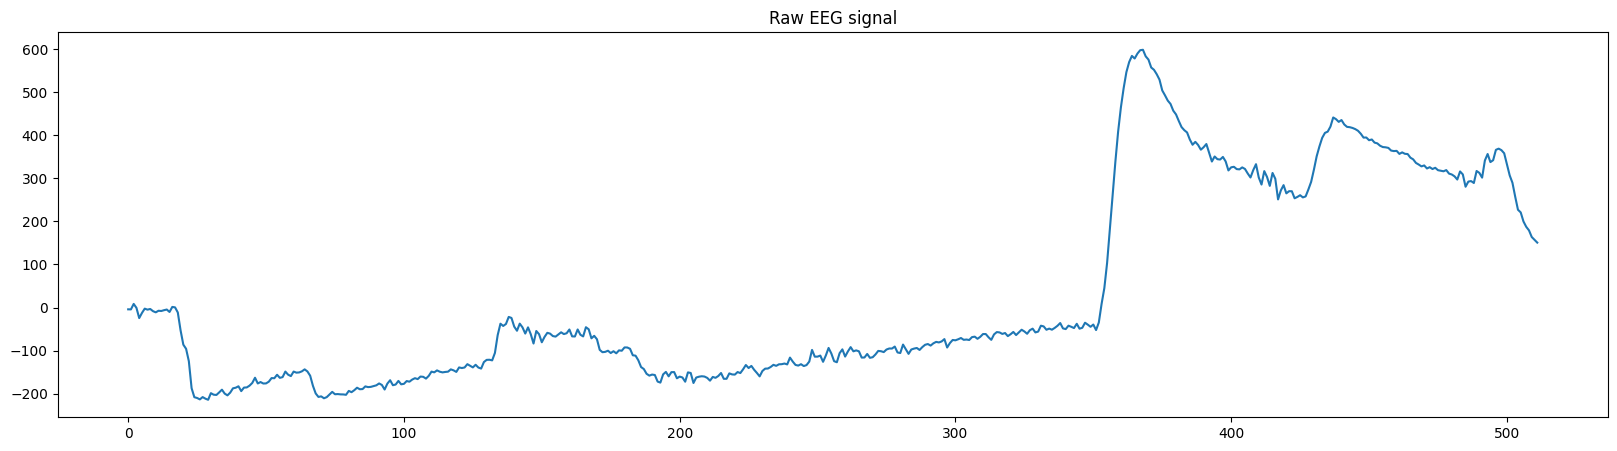

In [19]:
samplenum = 1
plt.figure(figsize=(20,5))
plt.title('Raw EEG signal')
plt.plot(x_raw[samplenum])

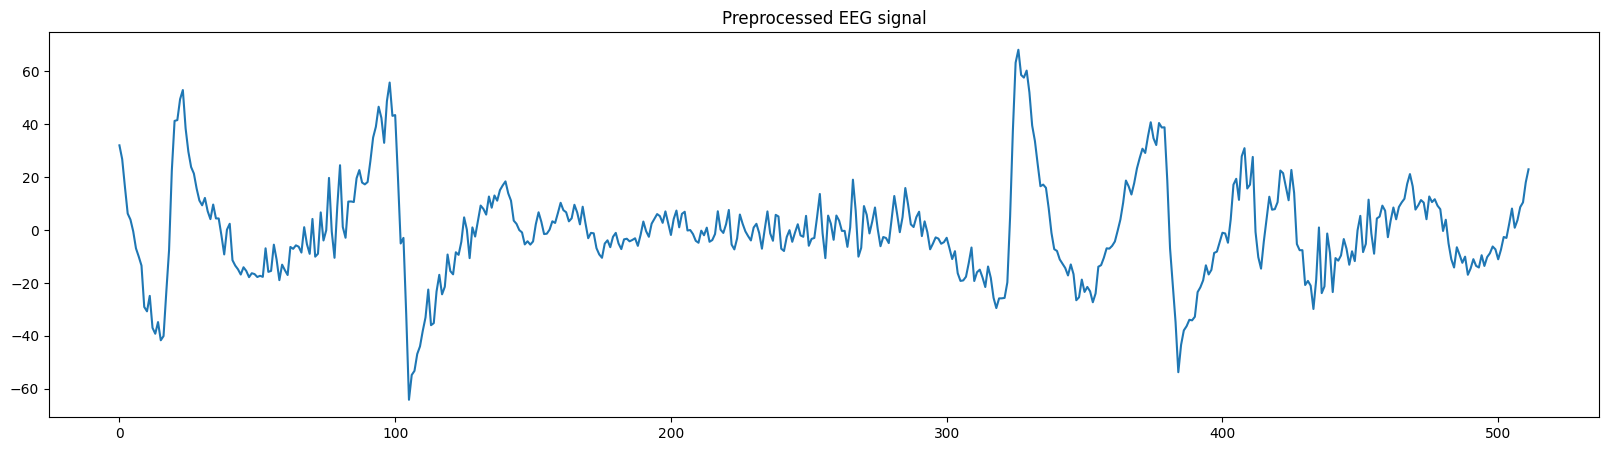

In [20]:
plt.figure(figsize=(20,5))
plt.title('Preprocessed EEG signal')
plt.plot(x[samplenum])

In [22]:
import random
# caseid
caseids = list(np.unique(c))
random.shuffle(caseids)

# Split dataset into training and testing data
ntest = max(1, int(len(caseids) * 0.2))
caseids_train = caseids[ntest:]
caseids_test = caseids[:ntest]

train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)
x_train = x[train_mask]
y_train = y[train_mask]
x_test = x[test_mask]
y_test = y[test_mask]
b_test = b[test_mask]
c_test = c[test_mask]

print('====================================================')
print('total: {} cases {} samples'.format(len(caseids), len(y)))
print('train: {} cases {} samples'.format(len(np.unique(c[train_mask])), len(y_train)))
print('test {} cases {} samples'.format(len(np.unique(c_test)), len(y_test)))
print('====================================================')

total: 10 cases 101925 samples
train: 8 cases 85417 samples
test 2 cases 16508 samples


In [ ]:
######### TODO 3 #########
import keras.models
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, LayerNormalization, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, concatenate, multiply, dot, MultiHeadAttention
from keras.callbacks import EarlyStopping, ModelCheckpoint

clayer = 2 # Number of convolution layer
fnode = 32 # Number of node in fully connected layer
nfilt = 16 # Number of filter
filtsize = 5 # Filter size
pooltype = 'avg' # Pooling type
poolsize = 2 # Pooling size
droprate = 0.2   # Dropout rate in fully connected layer

odir = '{}cases_{}sec'.format(MAX_CASES, SEGLEN // SRATE)
odir += '_cnn{}+{} filt{} size{} pool{} {} do{}'.format(clayer+1, fnode, nfilt, filtsize, poolsize, pooltype, droprate)
print("============================")
print(odir)
print("============================")

######### TODO 3 : Step 1 #########
# Make model using functional API
out = inp = Input(shape=(x_train.shape[1], 1))

for i in range(clayer):
    out = Conv1D(filters=nfilt, kernel_size=filtsize, padding='same', activation='relu')(out)
    out = MaxPooling1D(poolsize, padding='same')(out)

out = GlobalAveragePooling1D()(out)
out = Dropout(droprate)(out)
out = Dense(fnode)(out)
out = Dropout(droprate)(out)
out = Dense(1)(out)


model = Model(inputs=[inp], outputs=[out])
model.summary()

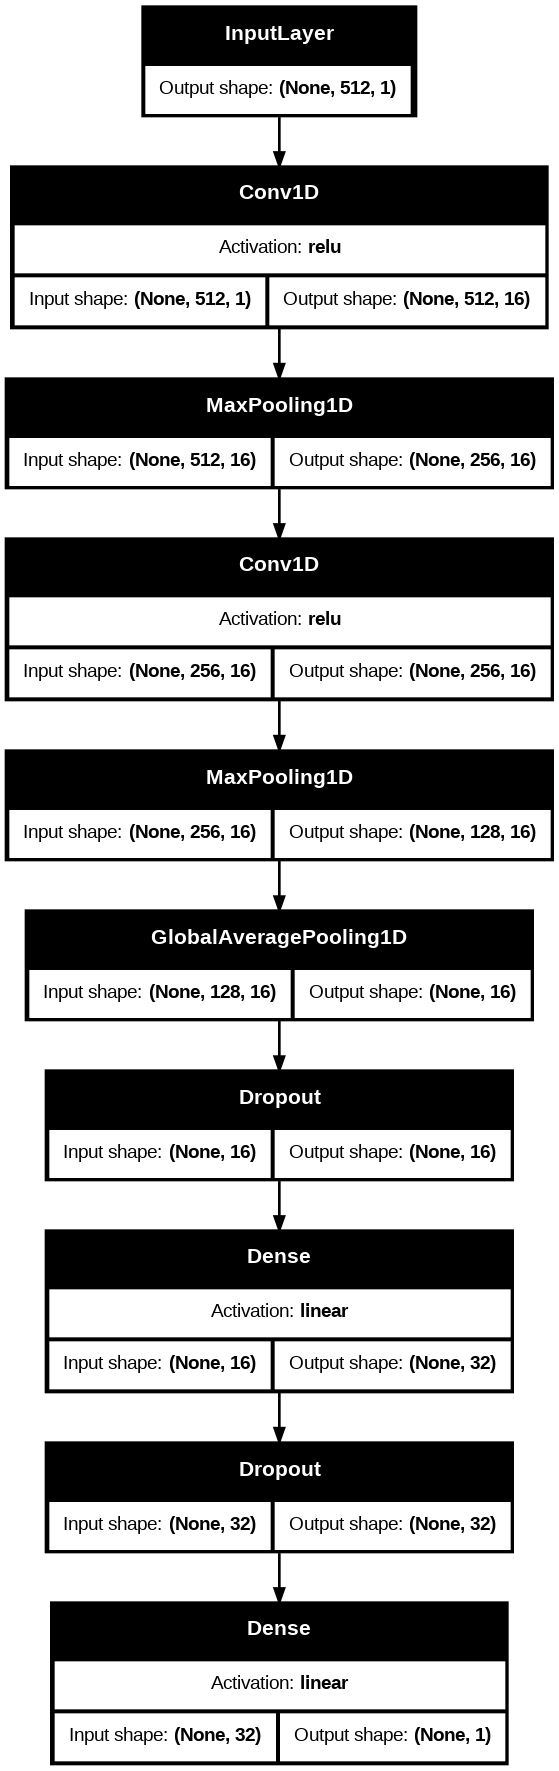

In [25]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
######### TODO 4 #########

######### TODO 4 : Step 1 #########
#1 Compile model
# 1) 손실함수: mean absolute error, 2) 평가방법: mean absolute error, 3) 옵티마이저: adam

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

######### TODO 4 : Step 2 #########
#2 Train model
# 1) validation split size: 20%, 2) epoch: 20 이상,  3) 미니배치크기: 1024,  4) Early stopping: 검증셋에서 mae 값이 3번 연속으로 더이상 감소하지 않을 시.
hist = model.fit(x_train[..., None], y_train, validation_split=0.2, epochs=50, batch_size=1024,
                callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')])

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 407ms/step - loss: 0.9540 - mean_absolute_error: 0.9540 - val_loss: 0.5645 - val_mean_absolute_error: 0.5645
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 45s 467ms/step - loss: 0.3094 - mean_absolute_error: 0.3094 - val_loss: 0.4463 - val_mean_absolute_error: 0.4463
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 385ms/step - loss: 0.2507 - mean_absolute_error: 0.2507 - val_loss: 0.3248 - val_mean_absolute_error: 0.3248
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 365ms/step - loss: 0.2200 - mean_absolute_error: 0.2200 - val_loss: 0.2730 - val_mean_absolute_error: 0.2730
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 357ms/step - loss: 0.2080 - mean_absolute_error: 0.2080 - val_loss: 0.2513 - val_mean_absolute_error: 0.2513
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - loss: 0.2037 - mean_absolute_error: 0.2037 - val_loss: 0.2427 - val_mean_absolute_error: 0.2427
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - loss: 0.1988 - mean_absolute_error: 0.1

In [ ]:
######### TODO 5 #########

######### TODO 5 : Step 1 #########
# Prediction
pred_test = model.predict(x_test[..., None], batch_size=1024).flatten()


######### TODO 5 : Step2 #########
# Calculate the total performance (mean absolute error)
test_mae = np.mean(np.abs(y_test - pred_test))


for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    pred_test[case_mask] = scipy.signal.medfilt(pred_test[case_mask], 31)


######### TODO 5 : Step3 #########
# Evaluation
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    case_len = np.sum(case_mask) # Calculate the length of each case
    if case_len == 0:
        continue

    our_mae = np.mean(np.abs(y_test[case_mask] - pred_test[case_mask])) # Calculate the mean absolute error for each case
    print('Total MAE={:.4f}, CaseID {}, MAE={:.4f}'.format(test_mae, caseid, our_mae))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='MAC') # Plotting MAC
    plt.plot(t, pred_test[case_mask], label='Ours ({:.4f})'.format(our_mae)) # Plotting predicted MAC
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.xlim([0, case_len])
    plt.ylim([0, 2])
    plt.show()

In [ ]:
import keras.models
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, LayerNormalization, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, concatenate, multiply, dot, MultiHeadAttention
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 1024

# Hyperparameters for model architecture
tests = {
    "nfilt" : [16, 32, 64],
    "fnode" : [32, 64, 128],
    "clayer" : [1, 2, 3, 4],
    "droprate" : [0.1, 0.2],
    "filtsize" : [5, 7, 9, 11],
    'poolsize' : [2, 4, 8],
    "pooltype" : ['avg', 'max']
}

# https://keras.io/examples/nlp/text_classification_with_transformer/
keys, values = zip(*tests.items())
permutations_dicts = it.product(*values)
permutations_dicts = list(permutations_dicts)
random.shuffle(permutations_dicts)
for nfilt, fnode, clayer, droprate, filtsize, poolsize, pooltype in permutations_dicts:

    keras.backend.clear_session()

    odir = '{}cases_{}sec'.format(MAX_CASES, SEGLEN // SRATE)
    odir += '_cnn{} filt{} size{} pool{} {} do{}'.format(clayer, nfilt, filtsize, poolsize, pooltype, droprate)
    print("============================")
    print(odir)
    print("============================")

    out = inp = Input(shape=(x_train.shape[1], 1))
    # Initialize cnn layer
    out = Conv1D(filters=nfilt, kernel_size=filtsize, padding='same')(out)
    # Multilayer conv
    for i in range(clayer):
        out = Conv1D(filters=nfilt, kernel_size=filtsize, padding='same', activation='relu')(out)
        out = MaxPooling1D(poolsize, padding='same')(out)
    if pooltype == "avg":
        out = GlobalAveragePooling1D()(out)
    else:
        out = GlobalMaxPooling1D()(out)

    if droprate:
        out = Dropout(droprate)(out)
    out = Dense(fnode)(out)
    if droprate:
        out = Dropout(droprate)(out)
    out = Dense(1)(out)


    model = Model(inputs=[inp], outputs=[out])
    model.summary()
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    hist = model.fit(x_train[..., None], y_train, validation_split=0.2, epochs=10, batch_size=BATCH_SIZE,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')])

    # Prediction
    pred_test = model.predict(x_test[..., None], batch_size=BATCH_SIZE).flatten()

    # Calculate the performance
    test_mae = np.mean(np.abs(y_test - pred_test))
    for caseid in np.unique(c_test):
        case_mask = (c_test == caseid)
        pred_test[case_mask] = scipy.signal.medfilt(pred_test[case_mask], 31)

    # Evaluation
    for caseid in np.unique(c_test):
        case_mask = (c_test == caseid)
        case_len = np.sum(case_mask)
        if case_len == 0:
            continue

        our_mae = np.mean(np.abs(y_test[case_mask] - pred_test[case_mask]))
        print('Total MAE={:.4f}, CaseID {}, MAE={:.4f}'.format(test_mae, caseid, our_mae))

        t = np.arange(0, case_len)
        plt.figure(figsize=(20, 5))
        plt.plot(t, y_test[case_mask], label='MAC')  # 측정 결과
        plt.plot(t, pred_test[case_mask], label='Ours ({:.4f})'.format(our_mae))
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.xlim([0, case_len])
        plt.ylim([0, 2])
        plt.show()